In [165]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
import os
import sys
__file__ = os.path.abspath('')
dir_path = '/'.join(os.path.realpath(__file__).split('/')[:-1])
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')
# sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_ez

# Loading in the DesignMatrix (and response) Data

In [113]:
df = pd.read_csv('../C39_2020_11_03_designMat.csv').drop('Unnamed: 0', axis=1)

if 'index' in df.columns:
    df = df.drop('index', axis=1)

display(df)

,nTrial,iBlock,ENLPenalty,TO,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
0,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.86484,890.27795
1,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.91985,911.16095
2,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,157.99931,907.63180
3,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,158.07393,911.70294
4,4.0,1.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,158.14862,910.94010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235727,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.91246,834.16540
235728,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.89035,835.16254
235729,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.86548,832.78430
235730,236.0,12.0,0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,153.86433,835.03350


# Converting photometry response to a differential rather than raw output

,grnL,grnL_diff
0,890.27795,NaN
1,911.16095,20.88300
2,907.63180,-3.52915
3,911.70294,4.07114
4,910.94010,-0.76284


Text(0.5, 0, 'Timestep Index')

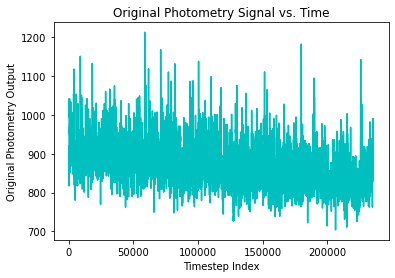

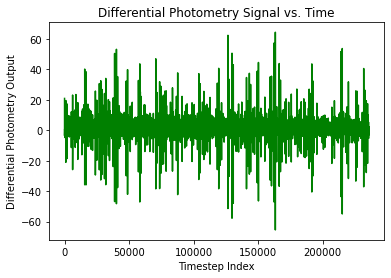

In [114]:
y_setup_col = 'grnL' # photometry response
df = sglm_ez.diff_cols(df, ['grnL'])

# Demonstrative first 5 timesteps of photometry signal vs. differential
display(df[['grnL', 'grnL_diff']].head())

# Plotting original photometry output (excluding first timestep)
plt.figure()
df['grnL'].iloc[1:].plot(color='c')
plt.title('Original Photometry Signal vs. Time')
plt.ylabel('Original Photometry Output')
plt.xlabel('Timestep Index')

# Plotting photometry differential output (excluding first timestep)
plt.figure()
df['grnL_diff'].iloc[1:].plot(color='g')
plt.title('Differential Photometry Signal vs. Time')
plt.ylabel('Differential Photometry Output')
plt.xlabel('Timestep Index')

# Specifying columns to retain for GLM fitting

In [115]:
X_cols = [
    # 'nTrial', # trial ID
    # 'iBlock', # block number within session
    # 'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1) # Keep
    # 'ENLPenalty', # lick during ENL period (no directionality yet, 0,1) # Keep
    # # 'Select', # binary selection lick
    # # 'Consumption', # consumption period (from task perspective)
    # # 'TO', # timeout trial
    # # 'responseTime', # task state cue to selection window
    # # 'ENL', # task state ENL window
    # 'Cue', # task state Cue window # Keep (and all after)
    # 'decision', # choice lick direction (aligned to select but with directionality -1,1)
    # 'switch', # switch from previous choice on selection (-1,1)
    # 'selR', # select reward (-1,1) aligned to selection
    # 'selHigh', # select higher probability port (-1,1)
    # 'Reward', # reward vs no reward during consumption period (-1,1)
    # 'post', # log-odds probability

    'nTrial',
    'iBlock',
    'ENLPenalty',
    # 'TO',
    'responseTime',
    'Cue',
    'decision',
    'switch',
    'selReward',
    'post',
    'lickReward',
    'lickNoReward',
    'lickLeft',
    'lickRight',
    'lickSwitch',
    'grnR',
    'grnL'
]

y_col = 'grnL_diff'

In [6]:
# plt.plot(X_setup['post'].iloc[:20000])
# plt.ylim

# Keep only relevant columns specified above

In [116]:
dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1


<AxesSubplot:>

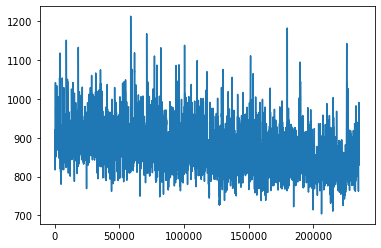

In [129]:
dfrel['grnL'].iloc[:].plot()

<AxesSubplot:>

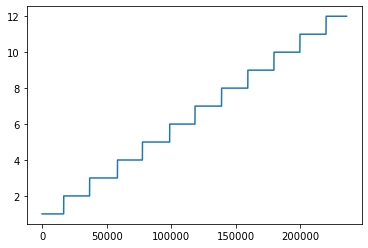

In [133]:
dfrel['iBlock'].iloc[:].plot()

# Timeshift all non-response columns forward and backward ts timesteps

In [8]:

dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[2:], neg_order=-10, pos_order=10)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[2:], neg_order=-10, pos_order=10)
# X_setup = sglm_ez.diff_cols(X_setup, ['A', 'B'])
# X_setup = sglm_ez.setup_autoregression(X_setup, ['B'], 4)

dfrel = dfrel.dropna()


In [9]:
X_setup = dfrel[X_cols]
# X_setup = dfrel[X_cols_sftd]
y_setup = dfrel[y_col]

X_setup.head()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.45584,917.72960
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.48213,919.08923
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.50370,919.03200
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.51870,919.99945
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.52820,919.73600


<AxesSubplot:>

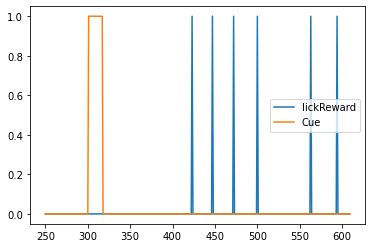

In [10]:
X_setup.iloc[240:600, [9, 4]].plot() # Make this tone one point — make it binned (one and only one point) — use tone duration as binning factor, then make it look like a delta function
# Data has to be collapsed based on when tone starts

In [11]:
# Sum of values in binning windows

In [12]:
X_setup.groupby(['nTrial']).count()

,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
nTrial,,,,,,,,,,,,,,,
4.0,975,975,975,975,975,975,975,975,975,975,975,975,975,975,975
5.0,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
6.0,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073,1073
7.0,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054,1054
8.0,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231.0,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102
232.0,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019,1019
233.0,980,980,980,980,980,980,980,980,980,980,980,980,980,980,980


In [13]:
# # investigate_X = X_setup[[_ for _ in X_setup.columns if _ not in ['nTrial', 'iBlock', 'TO', 'Select', 'Consumption', 'selHigh']]]
# # (investigate_X.corr()-np.eye(investigate_X.shape[1])).abs().max(axis=1)

# from sklearn.decomposition import PCA
# pca = PCA()
# X_setup_pca = pca.fit_transform(X_setup[[_ for _ in X_setup.columns if _ != 'TO']].iloc[:, 2:])



In [14]:
# %matplotlib inline
# plt.plot(pca.explained_variance_[1:])
# pca.explained_variance_.min()

In [15]:
pd.DataFrame(X_setup).corr()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
nTrial,1.000000,0.996422,-0.002267,0.056916,0.001156,-0.002863,0.000791,-0.001478,-0.003007,-0.002421,-0.001519,0.004505,-0.010075,0.000170,-0.937968,-0.454164
iBlock,0.996422,1.000000,-0.002270,0.061686,0.001131,-0.002583,0.001050,-0.001658,-0.002994,-0.003076,-0.000916,0.003596,-0.009727,0.000419,-0.934490,-0.456689
ENLPenalty,-0.002267,-0.002270,1.000000,-0.001110,-0.000465,0.000024,0.000083,-0.000053,-0.000079,-0.000319,-0.000084,0.047217,-0.000219,-0.000086,0.002230,-0.001439
responseTime,0.056916,0.061686,-0.001110,1.000000,-0.013552,-0.021718,-0.074922,0.047428,0.070911,-0.027822,-0.007367,0.003355,0.002120,0.013485,-0.043961,-0.074627
Cue,0.001156,0.001131,-0.000465,-0.013552,1.000000,0.000882,0.003042,-0.001925,-0.002879,-0.011662,-0.003088,-0.009856,-0.008017,-0.003157,-0.006599,-0.079041
decision,-0.002863,-0.002583,0.000024,-0.021718,0.000882,1.000000,0.210667,-0.004385,0.395226,0.000604,0.000160,-0.247345,0.196405,-0.011241,0.001475,-0.006039
switch,0.000791,0.001050,0.000083,-0.074922,0.003042,0.210667,1.000000,-0.434799,-0.484745,0.002085,0.000552,-0.198409,-0.136019,0.046194,-0.002297,-0.003744
selReward,-0.001478,-0.001658,-0.000053,0.047428,-0.001925,-0.004385,-0.434799,1.000000,0.331614,-0.001320,-0.000349,0.099872,0.118499,0.056670,0.001497,0.000689
post,-0.003007,-0.002994,-0.000079,0.070911,-0.002879,0.395226,-0.484745,0.331614,1.000000,-0.001973,-0.000522,0.061353,0.278087,0.181455,0.002898,0.002783
lickReward,-0.002421,-0.003076,-0.000319,-0.027822,-0.011662,0.000604,0.002085,-0.001320,-0.001973,1.000000,-0.002116,0.712075,0.571837,0.179764,0.006983,0.064652


In [16]:
(pd.DataFrame(X_setup).corr() - np.eye(X_setup.shape[1])).abs().max(axis=1)

nTrial          0.996422
iBlock          0.996422
ENLPenalty      0.047217
responseTime    0.074922
Cue             0.079041
decision        0.395226
switch          0.484745
selReward       0.434799
post            0.484745
lickReward      0.712075
lickNoReward    0.177203
lickLeft        0.712075
lickRight       0.571837
lickSwitch      0.193297
grnR            0.937968
grnL            0.487655
dtype: float64

In [17]:
# pd.DataFrame(X_setup_pca).corr()

In [18]:
X_setup.describe()

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
count,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000,235712.000000
mean,118.906110,6.470880,0.000013,0.088298,0.016732,-0.000208,-0.000717,0.000454,0.000413,0.007929,0.000560,0.005676,0.003763,0.000585,155.323962,866.210502
std,67.001478,3.359779,0.003568,0.283729,0.128267,0.030758,0.030750,0.030755,0.018692,0.088692,0.023658,0.075128,0.061228,0.024189,1.053817,52.263226
min,4.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153.049130,703.700800
25%,60.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.457058,830.452300
50%,119.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,155.125440,861.684420
75%,177.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.064590,895.211000
max,235.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988804,1.000000,1.000000,1.000000,1.000000,1.000000,158.794200,1212.781100


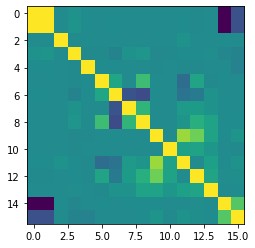

In [19]:
plt.imshow(X_setup.corr())

In [20]:
X_setup

,nTrial,iBlock,ENLPenalty,responseTime,Cue,decision,switch,selReward,post,lickReward,lickNoReward,lickLeft,lickRight,lickSwitch,grnR,grnL
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.45584,917.72960
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.48213,919.08923
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.50370,919.03200
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.51870,919.99945
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.52820,919.73600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235717,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.34094,841.02045
235718,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.32259,840.68680
235719,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.28929,839.44165
235720,235.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154.24985,839.26710


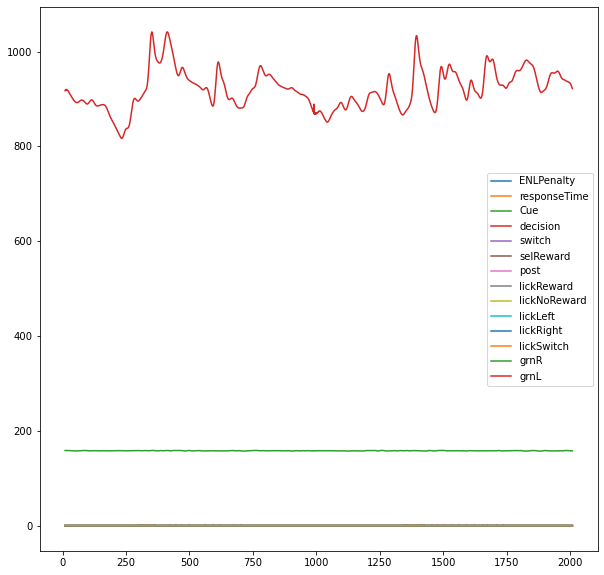

In [21]:
plt.figure(figsize=(10,10))
plt.plot(X_setup.iloc[:2000, 2:])
plt.legend(X_setup.columns[2:])

In [22]:
for col in X_setup.columns:
    print(f'{col}:', X_setup.query(f'{col} > 0').groupby(['nTrial', col])['post'].count().min())

nTrial: 856
iBlock: 856
ENLPenalty: 1
responseTime: 6
Cue: 17
decision: 1
switch: 1
selReward: 1
post: 1
lickReward: 5
lickNoReward: 1
lickLeft: 1
lickRight: 1
lickSwitch: 1
grnR: 1
grnL: 1


In [23]:
sglm_ez.timeshift_cols(X_setup, [_ for _ in X_setup.columns[2:] if _ not in ['Cue', 'Reward', 'post']], neg_order=0, pos_order=100)
sglm_ez.timeshift_cols_by_signal_length(X_setup, ['Cue', 'Reward', 'post'], neg_order=0, pos_order=1000, shift_amt_ratio=2).iloc[:50]

mnts: 17, sar: 2


UndefinedVariableError: name 'Reward' is not defined

In [ ]:
X_setup

,nTrial,iBlock,CuePenalty,ENLPenalty,Cue,decision,switch,selR,selHigh,Reward,post
10,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
12,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
13,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
14,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
234913,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234914,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234915,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604
234916,239.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.958604


In [ ]:
y_setup 

10       -1.94960
11       -0.06610
12       -1.97530
13       -0.36664
14       -1.94936
           ...   
234913    0.07515
234914    0.30675
234915    0.19510
234916    0.44236
234917    0.28564
Name: grnL_diff, Length: 234908, dtype: float64

In [167]:
import matplotlib.pyplot as plt
import numpy as np

def make_cv_indices(
    cv, 
    groups, 
    cmap_cv=plt.cm.binary, 
    cmap_data=plt.cm.binary, 
    lw=20, 
    plot_pref=True):

    """Create a sample plot for indices of a cross-validation object."""

    X = np.arange(len(groups))
    y = np.arange(len(groups))
    cv_idx = list(cv.split(X=X , y=y , groups=groups))
    
    n_splits = cv.n_splits
    # Generate the training/testing visualizations for each CV split
    if plot_pref:
        fig, ax = plt.subplots()

        for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
            # Fill in indices with the training/test groups
            indices = np.array([np.nan] * len(X))
            indices[tt] = 1
            indices[tr] = 0

            # Visualize the results
            ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                       c=indices, marker='_', lw=lw, cmap=cmap_cv,
                       vmin=-.2, vmax=1.2)

        ax.scatter(range(len(X)), [ii + 1.5] * len(X),
                   c=groups, marker='_', lw=lw, cmap=cmap_data)

        # Formatting
        yticklabels = list(range(n_splits)) + ['group']
        ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
               xlabel='Sample index', ylabel="CV iteration",
               ylim=[n_splits+1.2, -.2], xlim=[0, X.shape[0]])
        ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return cv_idx


def group_split(n_splits, n_samples, group_size, test_size=0.5):
    '''
    Makes cross-validation indices
    RH 2021
    Args:
        n_splits (int):
            Number of splits to perform
        n_samples (int):
            Number of samples
        group_size (int):
            Number of samples per group
        test_size (scalar):
            Fraction of samples in test set
    
    Returns:
        cv_idx (list):
            List of 2 lists.
            Outer list entries: Splits
            Inner list entries: Train, Test indices
    '''
    from sklearn.model_selection import GroupShuffleSplit
    
    cv = GroupShuffleSplit(n_splits, test_size=test_size)
    return list(cv.split(X=np.arange(n_samples), y=np.arange(n_samples), groups = np.arange(n_samples)//group_size))


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """
    Create a sample plot for indices of a cross-validation object.
    from here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    """

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, 
                #    cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw,
                # cmap=cmap_data
                )

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, 
            #    cmap=cmap_data
               )

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2],
            # xlim=[0, 100]
            )
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

IndexError: index 37049 is out of bounds for axis 0 with size 36969

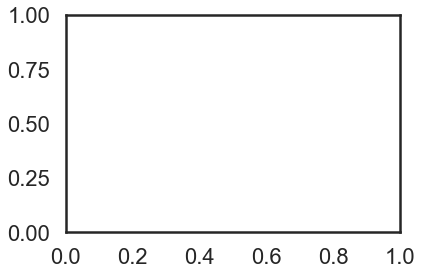

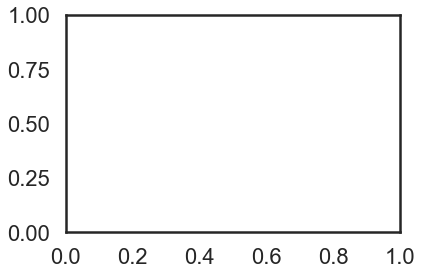

In [168]:
cv = GroupShuffleSplit()
fig = plt.figure()
ax = plt.axes()
make_cv_indices(cv, X_setup, y_setup, X_setup['nTrial'], ax, 5, )

In [ ]:
make_cv_indices(cv, X_setup['nTrial'])

NameError: name 'make_cv_indices' is not defined

In [219]:
import pandas as pd
df = pd.read_csv(f'../lynne-data-zs2.csv')
df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

# .drop('Unnamed: 16', axis=1).drop('Unnamed: 17', axis=1) # .drop('index', axis=1)

print(df.columns)

df = df.rename({'center port occupancy': 'cpo',
                'center port entry': 'cpn',
                'center port exit': 'cpx',

                'left port occupancy': 'lpo',
                'left port entry': 'lpn',
                'left port exit': 'lpx',
                'left licks': 'll',

                'right port occupancy': 'rpo',
                'right port entry': 'rpn',
                'right port exit': 'rpx',
                'right licks': 'rl',

                'no reward': 'nr',
                'reward': 'r',

                'gdFF (Ach3.0)': 'gdFF',
                'zscored red (rGRAB-DA)': 'rdFF'}, axis=1)

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = df['nr'].replace(0, np.nan) * 2.0
df['event_col_c'] = df['r'].replace(0, np.nan) * 3.0

df['event_col'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col'] = df['event_col'].bfill()
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0

df['nTrial'] = df['trial_start_flag'].cumsum().shift(-10).ffill()


Index(['time (msec)', 'center port entry', 'center port occupancy',
       'center port exit', 'left port entry', 'left port occupancy',
       'left port exit', 'left licks', 'right port entry',
       'right port occupancy', 'right port exit', 'right licks', 'no reward',
       'reward', 'zscored green (Ach3.0)', 'zscored red (rGRAB-DA)'],
      dtype='object')


In [185]:
df['r'].iloc[4300:4500].sum()

2.0

<AxesSubplot:>

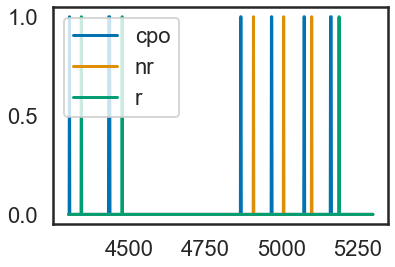

In [186]:
df[['cpo','nr','r']].iloc[4300:5300].plot()

In [187]:
# function [idx, val] = closest_v2(testArr,val)
# tmp=find(testArr<=val);
# idx=tmp(end);
# val=testArr(idx);

df['cpo']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
37329    NaN
37330    NaN
37331    NaN
37332    NaN
37333    NaN
Name: cpo, Length: 37334, dtype: float64

In [188]:
import numpy as np

df['event_col_a'] = ((df['cpo'].diff() > 0)*1).replace(0, np.nan) * 1.0
df['event_col_b'] = df['nr'].replace(0, np.nan) * 2.0
df['event_col_c'] = df['r'].replace(0, np.nan) * 3.0

df['event_col'] = df['event_col_a'].combine_first(df['event_col_b']).combine_first(df['event_col_c'])

df = df.drop(['event_col_a', 'event_col_b', 'event_col_c'], axis=1)

df['event_col'] = df['event_col'].bfill()
df['trial_start_flag'] = (df['event_col'] == 1.0)&(df['event_col'].shift(-1) != df['event_col']) * 1.0
df['nTrial'] = df['trial_start_flag'].cumsum().shift(-20)

<AxesSubplot:>

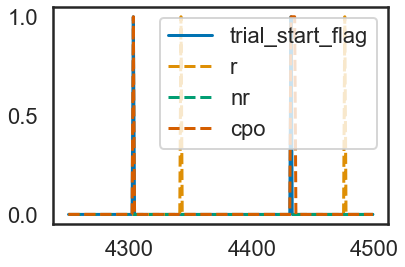

In [189]:
(df.iloc[4250:4500][['trial_start_flag', 'r', 'nr', 'cpo']] * 1.0).plot(style=['-', '--', '--', '--'])

# Define trial splits based on 500 ms (10 timesteps) prior to the center port occupancy that begins a trial.

<AxesSubplot:>

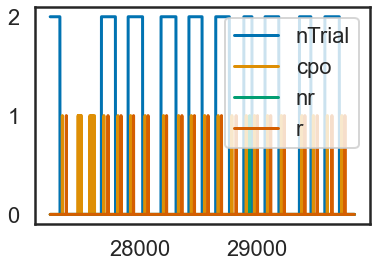

In [190]:
# df['nTrial'] = df['trial_start_flag'].cumsum().shift(-10).ffill() / 10
(df[['nTrial', 'cpo', 'nr', 'r']].eval('nTrial = (nTrial % 2)*2')).iloc[-10100:-7500].plot()

<AxesSubplot:>

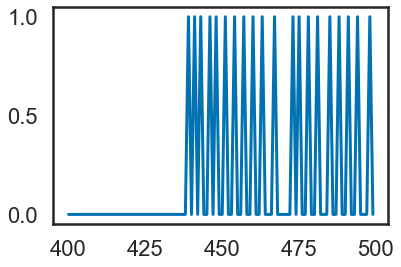

In [191]:
df['rl'].iloc[400:500].plot()

<AxesSubplot:>

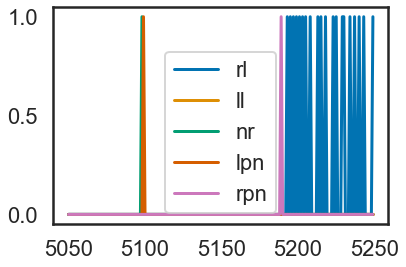

In [192]:
df[['rl','ll','nr','lpn','rpn']].iloc[5050:5250].plot()

<AxesSubplot:>

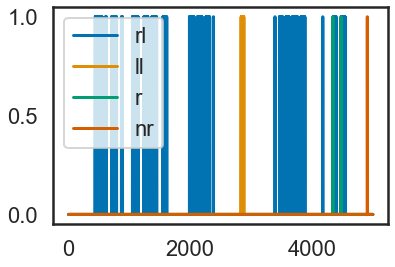

In [193]:
df[['rl','ll','r','nr']].iloc[:5000].plot()


In [210]:
y_setup_col = 'rdFF' # photometry response
df = sglm_ez.diff_cols(df, ['rdFF'])

X_cols = [
    'nTrial',
    #'cpo',
    'cpn', 'cpx',
    #'lpo',
    'lpn', 'lpx',
    'll',
    #'rpo',
    'rpn', 'rpx',
    'rl',
    'nr', 'r'
]

# y_col = 'gdFF'
y_col = 'rdFF'
# y_col = 'grnR'

dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1

print(dfrel)
print(X_cols)

neg_order = -20
pos_order = 20


dfrel = sglm_ez.timeshift_cols(dfrel, X_cols[1:], neg_order=neg_order, pos_order=pos_order)
X_cols_sftd = sglm_ez.add_timeshifts_to_col_list(X_cols, X_cols[1:], neg_order=neg_order, pos_order=pos_order)

print(dfrel.shape)
print(X_cols_sftd)

dfrel = dfrel.dropna()

X_setup = dfrel[X_cols_sftd].copy()
y_setup = dfrel[y_col].copy()

X_setup.head()


       nTrial  cpn  cpx  lpn  lpx   ll  rpn  rpx   rl   nr    r      rdFF
0         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.002009
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.005315
2         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.009356
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.013676
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.016854
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...
37329     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN
37330     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN
37331     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN
37332     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN
37333     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN

[37334 rows x 12 columns]
['nTrial', 'cpn', 'cpx', 'lpn', 'lpx', 'll', 'rpn', 'rpx', 'rl', 'nr', 'r']
(37334, 4

,nTrial,cpn,cpx,lpn,lpx,ll,rpn,rpx,rl,nr,...,cpn_20,cpx_20,lpn_20,lpx_20,ll_20,rpn_20,rpx_20,rl_20,nr_20,r_20
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
X_tr = X_setup[:-1000]
y_tr = y_setup[:-1000]

X_te = X_setup[-1000:]
y_te = y_setup[-1000:]


best_params = {'max_iter': 1000, 'alpha': 0.00001, 'l1_ratio': 0.1, 'fit_intercept': True}
glm = sglm_ez.fit_GLM(X_tr, y_tr, **best_params)

In [212]:
glm.model.score(X_tr, y_tr), glm.model.score(X_te, y_te)

(0.10373844300798796, 0.12984276063579303)

<AxesSubplot:>

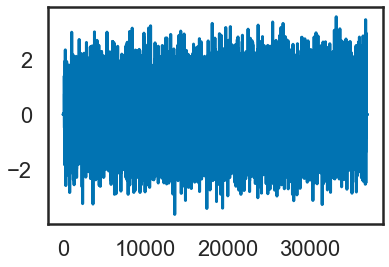

In [213]:
df['rdFF'].iloc[:].plot()

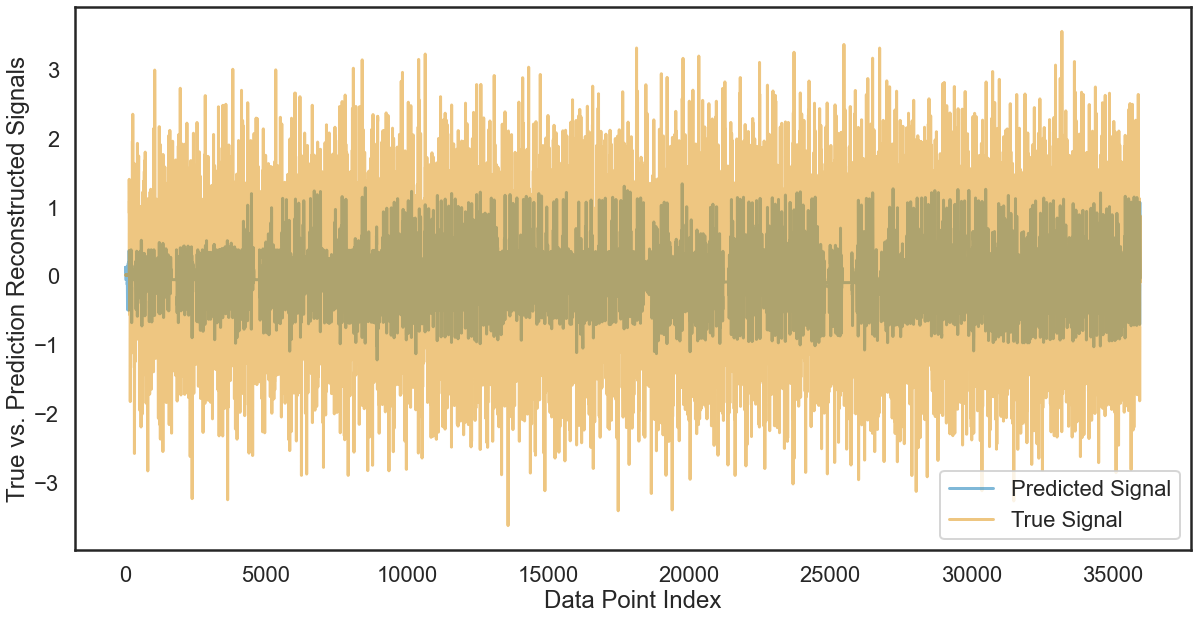

In [215]:
# sglm_ez.reconstruct_signal(glm, X_tr.iloc[5000:10000], y_tr.iloc[5000:10000])
sglm_ez.reconstruct_signal(glm, X_tr, y_tr)